# Document Clustering

In this project, I used unsupervised learning models to cluster unlabeled documents into different groups and visualized the results.

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [2]:
#import three lists: titles and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [3]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print "We use " + str(len(stopwords)) + " stop-words from nltk library."
print stopwords[:10]

We use 153 stop-words from nltk library.
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your']


In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens=[]
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word not in stopwords:
                tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [5]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [6]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print vocab_frame_dict['angel']

angeles


# Part 3: TF-IDF

In [8]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))
tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print "In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms."

In total, there are 100 synoposes and 538 terms.


In [9]:
tfidf_model.get_params()

{'analyzer': u'word',
 'binary': False,
 'decode_error': u'strict',
 'dtype': numpy.int64,
 'encoding': u'utf-8',
 'input': u'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': u'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': u'(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [10]:
tf_selected_words = tfidf_model.get_feature_names()

# Calculate Document Similarity

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print cos_matrix

[[ 1.          0.1996283   0.23342595 ...,  0.3581728   0.3277855
   0.17714484]
 [ 0.1996283   1.          0.26626879 ...,  0.26910321  0.22856581
   0.10870124]
 [ 0.23342595  0.26626879  1.         ...,  0.27738654  0.24669308
   0.12805055]
 ..., 
 [ 0.3581728   0.26910321  0.27738654 ...,  1.          0.55040973
   0.08151334]
 [ 0.3277855   0.22856581  0.24669308 ...,  0.55040973  1.          0.13005234]
 [ 0.17714484  0.10870124  0.12805055 ...,  0.08151334  0.13005234  1.        ]]


# Part 4: K-means clustering

In [12]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [13]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [14]:
frame.head(10)

,rank,title,cluster
4,0,The Godfather,4
4,1,The Shawshank Redemption,4
3,2,Schindler's List,3
4,3,Raging Bull,4
4,4,Casablanca,4
4,5,One Flew Over the Cuckoo's Nest,4
4,6,Gone with the Wind,4
2,7,Citizen Kane,2
4,8,The Wizard of Oz,4
2,9,Titanic,2


In [15]:
print "Number of films included in each cluster:"
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
4,54
3,15
2,12
0,11
1,8


In [16]:
grouped = frame['rank'].groupby(frame['cluster'])
print "Average rank (1 to 100) per cluster:"
grouped.mean().to_frame()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,54.818182
1,47.125000
2,46.500000
3,37.266667
4,52.833333


In [17]:
print "<Document clustering result by K-means>"

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print "Cluster " + str(i) + " words:" ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print vocab_frame_dict[tf_selected_words[ind]] + ",",
    print
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print "Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): " 
    print ", ".join(cluster_movies)
    print

<Document clustering result by K-means>
Cluster 0 words: george, family, filmed, captain, performed, marries,
Cluster 0 titles (11 movies): 
The Sound of Music, Singin' in the Rain, It's a Wonderful Life, The Philadelphia Story, An American in Paris, The King's Speech, A Place in the Sun, Midnight Cowboy, Tootsie, Giant, Yankee Doodle Dandy

Cluster 1 words: water, ship, captain, bar, cross, death,
Cluster 1 titles (8 movies): 
Star Wars, 2001: A Space Odyssey, Chinatown, Raiders of the Lost Ark, Jaws, The Good, the Bad and the Ugly, The African Queen, Mutiny on the Bounty

Cluster 2 words: father, love, wife, marriages, relationship, life,
Cluster 2 titles (12 movies): 
Citizen Kane, Titanic, Vertigo, Forrest Gump, Amadeus, The Best Years of Our Lives, City Lights, It Happened One Night, Annie Hall, Good Will Hunting, The Green Mile, The Graduate

Cluster 3 words: soldiers, army, killing, general, commanded, war,
Cluster 3 titles (15 movies): 
Schindler's List, Lawrence of Arabia, The

## 4.2. Plot K-means Result

In [18]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

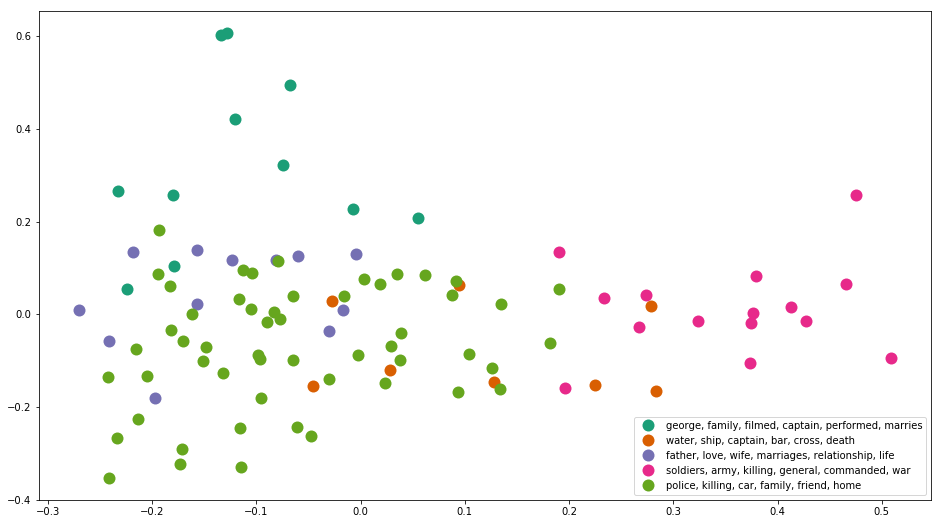

In [19]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

In [20]:
plt.close()

## Added: LDA

In [21]:
terms_dict = {tf_selected_words[x] : x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    all_words_stemmed = tokenization_and_stemming(i)
    for get_terms in all_words_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] = current_doc_stats[terms_dict[get_terms]] + 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

In [22]:
model = lda.LDA(n_topics=5, n_iter=500, random_state=1) 
# "model.topic_word_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
# Shape of "model.topic_word_" is (n_topics * num_of_selected_words)
# "model.doc_topic_" saves the document topic results, i.e. document topic matrix
# Shape of "model.doc_topic_" is (num_of_documents * n_topics)

In [23]:
model.fit(feature_matrix_synopses_tf)
topic_word = model.topic_word_  
n_top_words = 7

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    # top (n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 538
INFO:lda:n_words: 61218
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -484683
INFO:lda:<10> log likelihood: -428330
INFO:lda:<20> log likelihood: -412489
INFO:lda:<30> log likelihood: -406790
INFO:lda:<40> log likelihood: -403019
INFO:lda:<50> log likelihood: -400070
INFO:lda:<60> log likelihood: -398296
INFO:lda:<70> log likelihood: -397266
INFO:lda:<80> log likelihood: -395732
INFO:lda:<90> log likelihood: -395476
INFO:lda:<100> log likelihood: -394666
INFO:lda:<110> log likelihood: -394617
INFO:lda:<120> log likelihood: -393980
INFO:lda:<130> log likelihood: -393121
INFO:lda:<140> log likelihood: -392773
INFO:lda:<150> log likelihood: -392559
INFO:lda:<160> log likelihood: -392274
INFO:lda:<170> log likelihood: -391875
INFO:lda:<180> log likelihood: -392254
INFO:lda:<190> log likelihood: -391966
INFO:lda:<200> log likelihood: -391777
INFO:lda:<210> log likelihood: -391467
INFO:lda:<220> log likelihood: -3910

In [24]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print "<Document clustering result by LDA>"
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])
    print "Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " 
    print ', '.join(topic_doc_dict[i])
    print

<Document clustering result by LDA>
Cluster 0 words: george, war, soldiers, army, captain, commanded
Cluster 0 titles (10 movies): 
Schindler's List, Lawrence of Arabia, It's a Wonderful Life, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Patton, Dances with Wolves, Stagecoach, Mutiny on the Bounty

Cluster 1 words: car, away, police, meet, helping, apartment
Cluster 1 titles (13 movies): 
Titanic, The Silence of the Lambs, The Apartment, The Pianist, The French Connection, It Happened One Night, Fargo, The Graduate, The Maltese Falcon, Double Indemnity, Rebel Without a Cause, Rear Window, North by Northwest

Cluster 2 words: father, family, new, end, life, years
Cluster 2 titles (28 movies): 
The Godfather, Casablanca, Citizen Kane, The Godfather: Part II, Sunset Blvd., Forrest Gump, The Sound of Music, Singin' in the Rain, Amadeus, A Streetcar Named Desire, The Best Years of Our Lives, Doctor Zhiva